In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import optuna
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import random

In [3]:
# Cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
# Pre-computed mean and std
mean = [0.5177, 0.5003, 0.4125]
std = [0.2625, 0.2582, 0.2747]

# Data preparation
prepare = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
# Import data
data = datasets.ImageFolder(root='data/', transform=prepare)

# Train/Val/Test split
train_data, val_data = random_split(data, [0.8, 0.2])

# Implementing MobileNet v2

In [7]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        
        # Initial convolution layer
        self.initial_conv = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        # List of inverted residual blocks
        self.blocks = nn.ModuleList([
            self._make_block(32, 16, 1, 1),
            self._make_block(16, 24, 6, 2),
            self._make_block(24, 32, 6, 2),
            self._make_block(32, 64, 6, 2),
            self._make_block(64, 96, 6, 1),
            self._make_block(96, 160, 6, 2),
            self._make_block(160, 320, 6, 1)
        ])
        
        # Final layers
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(1280)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)
        
    def _make_block(self, in_channels, out_channels, expand_ratio, stride):
        return nn.Sequential(
            # Expansion layer
            nn.Conv2d(in_channels, in_channels * expand_ratio, kernel_size=1, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU(inplace=True),
            
            # Depthwise separable convolution
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio, kernel_size=3, stride=stride, padding=1, groups=in_channels * expand_ratio, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU(inplace=True),
            
            # Pointwise convolution
            nn.Conv2d(in_channels * expand_ratio, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.initial_conv(x)))
        for block in self.blocks:
            x = block(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
model = MobileNetV2().to(device)
print(model)

MobileNetV2(
  (initial_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1

In [9]:
# Hyperparameters (same as in MobileNet V2 paper)
decay = 0.9
lr = 0.0001 # Reduced learning rate because model was converging way too fast
momentum = 0.9
weight_decay = 0.00004

lr_decay_rate = 0.98

In [10]:
# Data augmentation (applied on every batch to diversify input data and reduce overfit)
def random_augment(batch):
    augmentation_list = [transforms.RandomHorizontalFlip(),
                         transforms.RandomVerticalFlip(),
                         transforms.RandomRotation(30),
                         transforms.RandomResizedCrop(32, scale=(0.8, 1.0))]
    
    # Pick a random transformation from the list
    transform = random.choice(augmentation_list)
    
    # Apply the transformation to each image in the batch
    images, labels = zip(*batch)
    images = [transform(image) for image in images]
    
    # Stack images into a tensor
    images = torch.stack(images, dim=0)
    return images, torch.tensor(labels)

In [11]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.RMSprop(model.parameters(),
                          alpha=decay,
                          lr=lr,
                          momentum=momentum,
                          weight_decay=weight_decay)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_rate)

In [12]:
num_epochs = 10
loss_values = []
verbose=True
early_stopping=True

In [13]:
# DataLoader for batching
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=random_augment)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)

In [14]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train() # Set to train mode
    for inputs, labels in train_loader:
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Feed-forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        # Add loss
        batch_loss = loss.item()
        running_loss += batch_loss
        loss_values.append(batch_loss)

    # Average loss for the epoch
    avg_loss = running_loss / len(train_loader)

    # Training accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    train_acc = correct / total

    # Validation accuracy
    model.eval()  # Eval mode
    correct = 0
    total = 0
    with torch.no_grad(): #No gradient
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    
    # Update the learning rate at the end of each epoch
    scheduler.step()
    
    if verbose == True:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
        print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

    if early_stopping==True and val_acc > 0.999:
        print("Achieved acceptable accuracy. Stopping early.")
        break

Epoch 1/10, Loss: 0.006814
Train accuracy: 1.0, Validation accuracy: 1.0
Achieved acceptable accuracy. Stopping early.


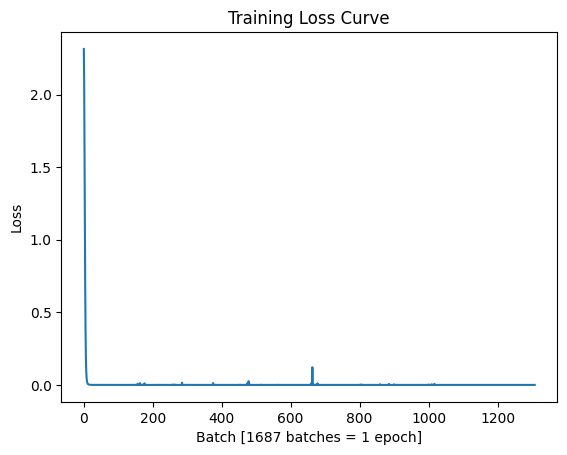

In [15]:
# Plotting Loss Curve
plt.plot(loss_values)
plt.xlabel('Batch [1309 batches = 1 epoch]')
#plt.xticks(range(1,11))
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [16]:
#with open('Models/MobileNetV2.pkl', 'wb') as file:
#    pickle.dump(model, file)

In [17]:
torch.save(model, 'Models/MobileNetV2.pkl')